## Finding entity classes in embeddings

In this notebook we're going to use embeddings to find entity classes and how they correlate with other things

In [7]:
%matplotlib inline
#import matplotlib

from sklearn import svm
import tensorflow as tf
from tensorflow.keras.utils import get_file
import os
import gensim
import numpy as np
import random
import requests
import geopandas as gpd
from IPython.core.pylabtools import figsize
import csv

figsize(12, 8)

#在windows环境安装geopandas
#pip install wheel
#pip install pipwin
#pipwin install numpy
#pipwin install pandas
#pipwin install shapely
#pipwin install gdal
#pipwin install fiona
#pipwin install pyproj
#pipwin install six
#pipwin install rtree
#pipwin install geopandas

as before, let's load up the model

In [20]:
MODEL = 'GoogleNews-vectors-negative300.bin'
path = './data/' + MODEL + '.gz'
unzipped = os.path.join('generated', MODEL)
if not os.path.isfile(unzipped):
    with open(unzipped, 'wb') as fout:
        zcat = subprocess.Popen(['zcat'],
                          stdin=open(path),
                          stdout=fout
                         )
        zcat.wait()

Most similar to a bunch of countries are some other countries!

In [23]:
model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)
model.most_similar(positive=['Germany'])

[('Austria', 0.7461061477661133),
 ('German', 0.7178748846054077),
 ('Germans', 0.6628647446632385),
 ('Switzerland', 0.6506868004798889),
 ('Hungary', 0.6504982709884644),
 ('Germnay', 0.649348258972168),
 ('Netherlands', 0.6437495946884155),
 ('Cologne', 0.6430779099464417),
 ('symbol_RSTI', 0.6389946937561035),
 ('Annita_Kirsten', 0.6342949271202087)]

In [24]:
model.most_similar(positive=['Annita_Kirsten'])

[('Braustolz_GmbH', 0.7545095086097717),
 ('DIARY_Economic_Indicators', 0.7334568500518799),
 ('##-##_#####_Burscheid', 0.7307888269424438),
 ('WKN_A#N#Y#_Symbol', 0.7260339260101318),
 ('Hoevelaken', 0.7067490220069885),
 ('BMW_###si_1min_##.###secs', 0.7050350904464722),
 ('Primera_EUROPE', 0.699741005897522),
 ('symbol_RSTI', 0.6925467252731323),
 ('Severin_Freund', 0.6898956894874573),
 ('However_Joern_Lauterjung', 0.6885738968849182)]

No we'll create a training set with countries and non countries and get a support vector machine to learn the difference.

In [25]:
countries = list(csv.DictReader(open('data/countries.csv')))
countries[:10]

[{'name': 'Canada', 'cc': 'ca', 'cc3': 'can'},
 {'name': 'Turkmenistan', 'cc': 'tm', 'cc3': 'tkm'},
 {'name': 'Ethiopia', 'cc': 'et', 'cc3': 'eth'},
 {'name': 'Swaziland', 'cc': 'sz', 'cc3': 'swz'},
 {'name': 'Czech_Republic', 'cc': 'cz', 'cc3': 'cze'},
 {'name': 'Cameroon', 'cc': 'cm', 'cc3': 'cmr'},
 {'name': 'UAE', 'cc': 'ae', 'cc3': 'are'},
 {'name': 'Liberia', 'cc': 'lr', 'cc3': 'lbr'},
 {'name': 'Netherlands', 'cc': 'nl', 'cc3': 'nld'},
 {'name': 'East_Timor', 'cc': 'tl', 'cc3': 'tls'}]

In [26]:
positive = [x['name'] for x in random.sample(countries, 40)]
negative = random.sample(model.key_to_index.keys(), 5000)
negative[:4]

['Rangeloff', 'Punch_Masenamela', 'Volcano_spews_ash', 'flagged_MV']

In [27]:
labelled = [(p, 1) for p in positive] + [(n, 0) for n in negative]
random.shuffle(labelled)
X = np.asarray([model[w] for w, l in labelled])
y = np.asarray([l for w, l in labelled])
X.shape, y.shape

((5040, 300), (5040,))

In [28]:
TRAINING_FRACTION = 0.3
cut_off = int(TRAINING_FRACTION * len(labelled))
clf = svm.SVC(kernel='linear')
clf.fit(X[:cut_off], y[:cut_off]) 

SVC(kernel='linear')

We did alright, 99.9% precision:

In [29]:
res = clf.predict(X[cut_off:])

missed = [country for (pred, truth, country) in 
 zip(res, y[cut_off:], labelled[cut_off:]) if pred != truth]

100 - 100 * float(len(missed)) / len(res), missed

(99.71655328798185,
 [('Greenland', 1),
  ('Samoa', 1),
  ('former_colonizer', 0),
  ('Luxembourg', 1),
  ('Gambia', 1),
  ('Bermuda', 1),
  ('United_States', 1),
  ('Brunei', 1),
  ('Kuwait', 1),
  ('Spassky', 0)])

In [35]:
all_predictions = clf.predict(model.vectors)

In [37]:
res = []
for word, pred in zip(model.index_to_key, all_predictions):
    if pred:
        res.append(word)
        if len(res) == 150:
            break
random.sample(res, 10)

['Italy',
 'Congo',
 'Germany',
 'Belgium',
 'Syria',
 'nations',
 'Tunisia',
 'Cuba',
 'Algeria',
 'Pyongyang']

In [38]:
country_to_idx = {country['name']: idx for idx, country in enumerate(countries)}
country_vecs = np.asarray([model[c['name']] for c in countries])
country_vecs.shape

(184, 300)

Quick sanity check to see what is similar to Canada:

In [39]:
dists = np.dot(country_vecs, country_vecs[country_to_idx['Canada']])
for idx in reversed(np.argsort(dists)[-10:]):
    print(countries[idx]['name'], dists[idx])

Canada 7.544024
New_Zealand 3.9619699
Finland 3.9392407
Puerto_Rico 3.838145
Jamaica 3.8102932
Sweden 3.8042789
Slovakia 3.703874
Australia 3.671101
Bahamas 3.6240416
United_States 3.5374339


Ranking countries for a specific term:

In [40]:
def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    vec = model[term]
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], float(dists[idx])) 
            for idx in reversed(np.argsort(dists)[-topn:])]

In [41]:
rank_countries('cricket')

[('Sri_Lanka', 5.92276668548584),
 ('Zimbabwe', 5.336524963378906),
 ('Bangladesh', 5.192489147186279),
 ('Pakistan', 4.948408126831055),
 ('Guyana', 3.9162838459014893),
 ('Barbados', 3.757995128631592),
 ('India', 3.7504401206970215),
 ('South_Africa', 3.6561501026153564),
 ('New_Zealand', 3.642028570175171),
 ('Fiji', 3.608567714691162)]

Now let's visualize this on a world map:

In [153]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


We can now plot some maps!

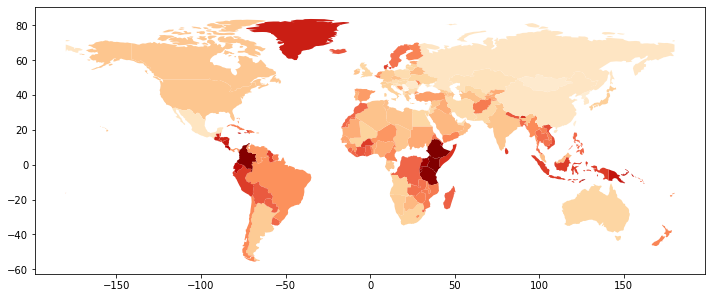

In [141]:
def map_term(term):
    d = {k.upper(): v for k, v in rank_countries(term, topn=0, field='cc3')}
    world[term] = world['iso_a3'].map(d)
    world[term] /= world[term].max()
    world.dropna().plot(term, cmap='OrRd')

map_term('coffee')

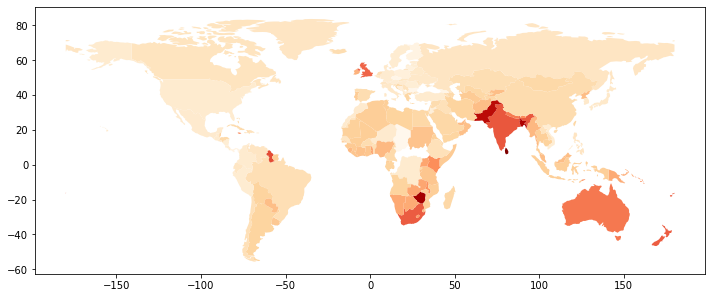

In [122]:
map_term('cricket')

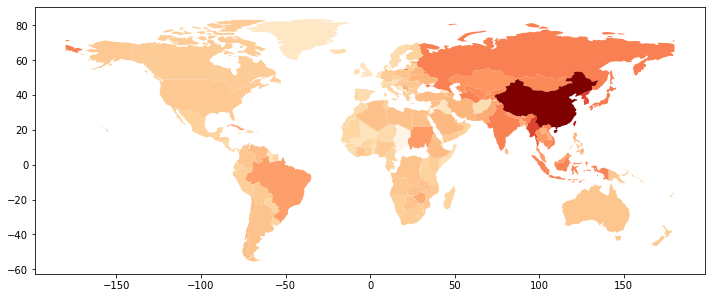

In [123]:
map_term('China')

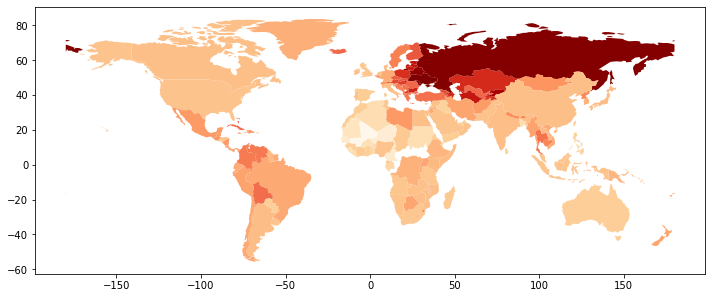

In [124]:
map_term('vodka')

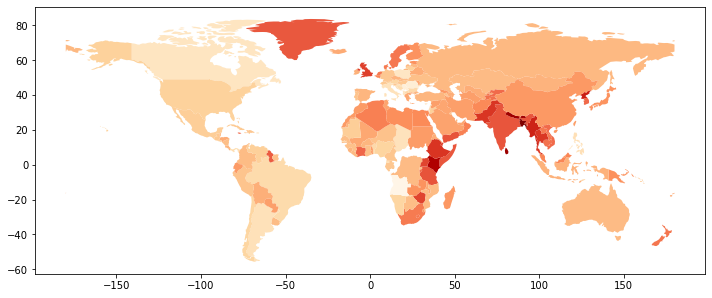

In [125]:
map_term('tea')

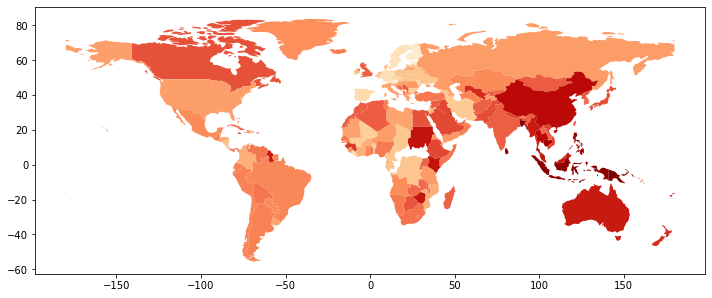

In [126]:
map_term('KFC')

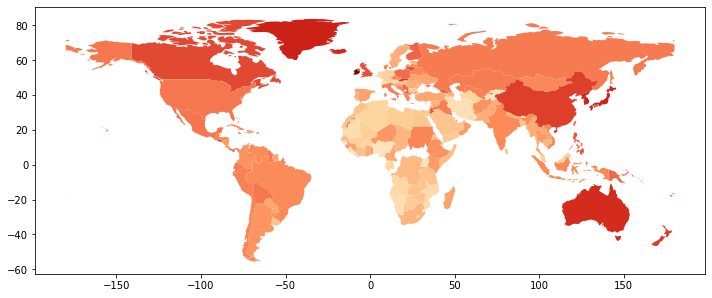

In [127]:
map_term('McDonald')

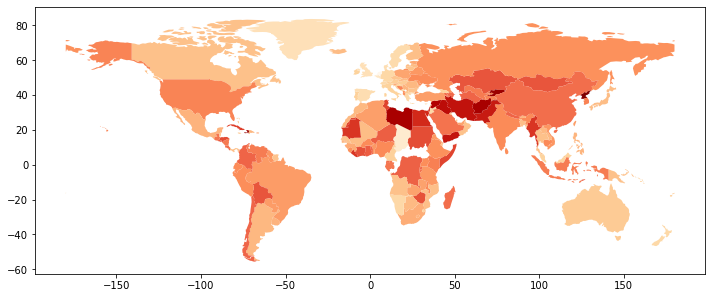

In [128]:
map_term('BarackObama')

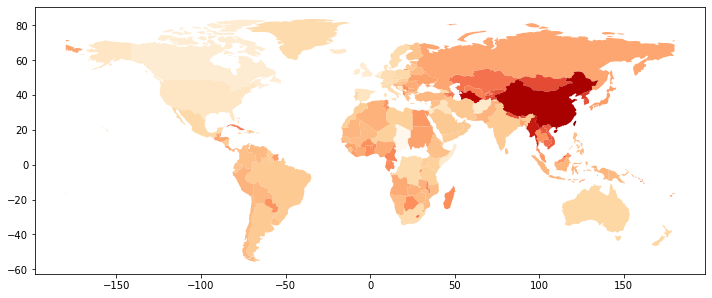

In [129]:
map_term('Xi')

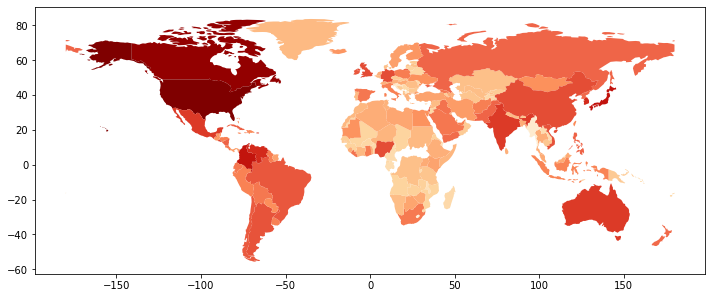

In [130]:
map_term('America')

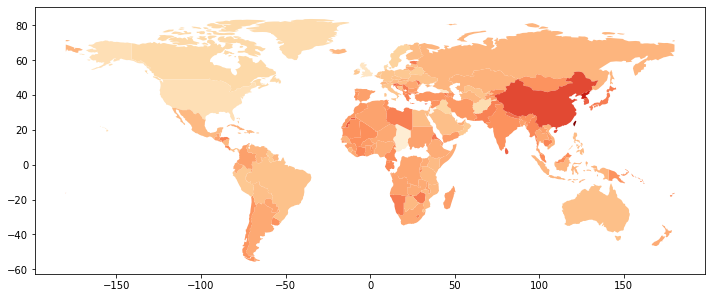

In [131]:
map_term('taiwan')

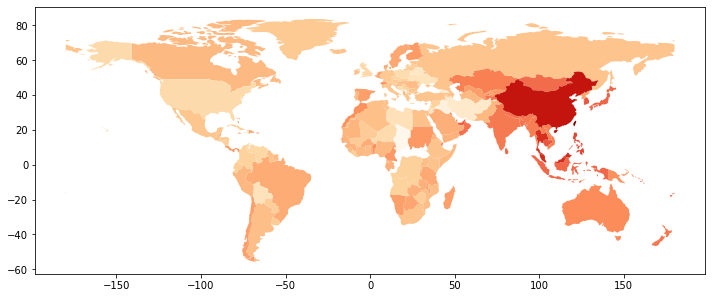

In [132]:
map_term('HongKong')

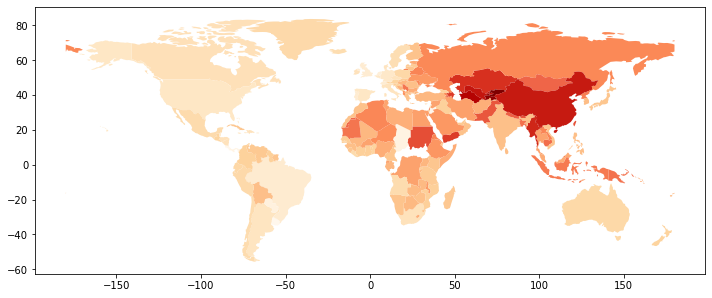

In [135]:
map_term('Xinjiang')

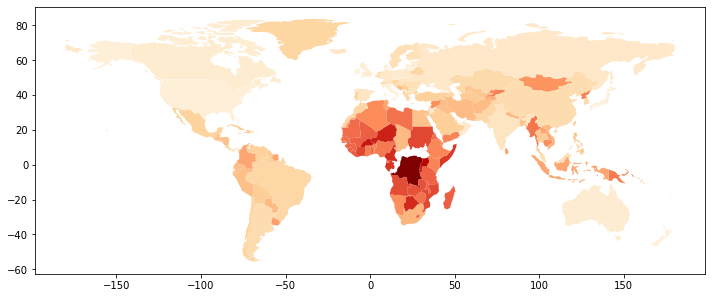

In [156]:
map_term('Ebola')

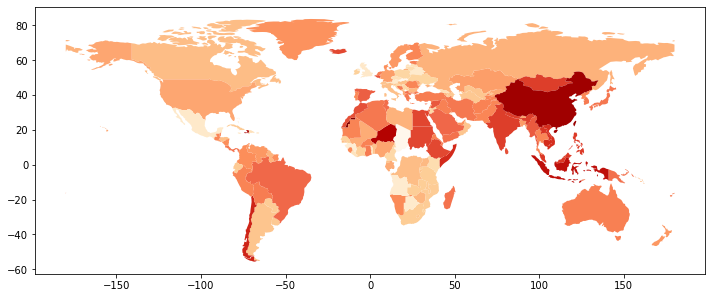

In [147]:
map_term('google')

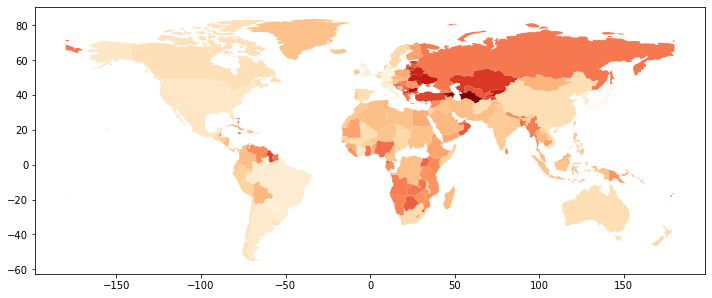

In [154]:
map_term('BTC')

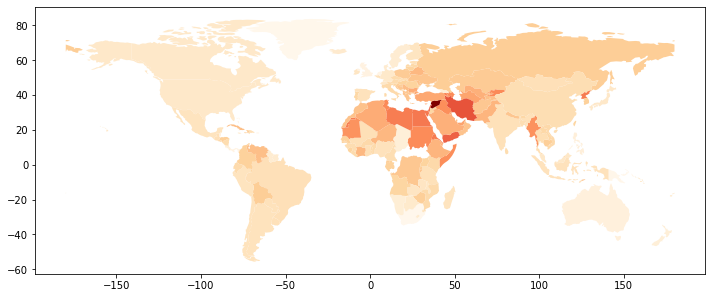

In [157]:
map_term('Syrian')

In [111]:
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,coffee,cricket,China,vodka,tea,KFC,McDonald,Trump,Xi
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.415027,0.609271,0.423152,0.251874,0.200086,0.833421,0.450037,0.517230,0.396862
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",0.969494,0.268171,0.353667,0.076928,0.535068,0.302214,-0.002821,0.083079,0.206794
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",0.495734,0.077895,0.324381,-0.177829,0.160867,0.461913,0.291077,0.467408,0.237656
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.210723,0.088765,0.378704,0.127661,-0.182036,0.575897,0.532209,0.134384,0.006847
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.216337,0.031172,0.397792,0.091227,-0.026502,0.293797,0.347255,0.232248,0.060243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",-0.155929,0.092870,0.470871,0.446460,-0.286762,0.549864,0.426758,0.350932,0.441234
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",-0.046268,0.022910,0.232920,0.414075,-0.386620,0.121402,0.430564,0.493596,0.165343
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
len(world)

177